## Topic modelling  : Tag suggestion 

The project consists on automatically tag stack overflow posts. 

When users write a question it can be beneficial for them and for other users to tag the topic into questions. 

Dataset : the data was optain by the following **SQL query on StackExchange Data Explorer**  below :   

SELECT TOP 50000 Id, PostTypeId, CreationDate, Title, Body, Tags, Score,

ViewCount, AnswerCount, CommentCount, FavoriteCount FROM Posts 

WHERE  PostTypeId = 1 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 

AND ViewCount > 10 AND CommentCount > 2 

AND AnswerCount > 1 AND Score > 5

In this notebook we will analyze and explore the query output and generate a clean corpus of text with the corresponding tags for further study and model selection.

- EDA : Short exploratory data analyses, univariate and multivariate 
- Posts selection 
- Post to bag-of-words representation 

The following image sums up this notebook : 


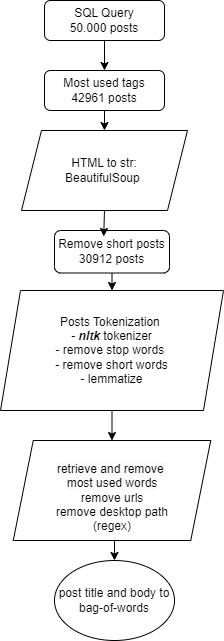

In [1]:
from IPython.display import Image, display
display(Image(filename='img/NLP-preproc.jpg'))

In [2]:
# Test if notebook running on google colab :  
from  tm_common import * 
IN_COLAB, output_dir = tm_get_working_config()
if IN_COLAB:
    pathToDataSet = f"{output_dir}QueryResults500000.csv"
else :
    pathToDataSet = "C:\dev\data\QueryResults.csv"

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates
import seaborn as sns 
import re 
import tqdm

from datetime import datetime
import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML

C:\Users\clara\AppData\Local\Temp\ipykernel_44448\10828533.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## EDA : Exploratory Data analysis

In [4]:
data = pd.read_csv(pathToDataSet)
df = data 

In [5]:
nb_posts = df.shape[0]
df.shape

(50000, 11)

In [6]:
df.head(2)

,Id,PostTypeId,CreationDate,Title,Body,Tags,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
0,20954805,1,2014-01-06 16:42:42,NLTK - Automatically translating similar words,<p><strong>Big picture goal:</strong> I am mak...,<python><algorithm><nltk><wordnet><gensim>,7,2698,2,3,0.0
1,2131740,1,2010-01-25 10:57:54,Online JSONP converter/wrapper,<p>I would like to fetch a source of file and ...,<web-services><json><cross-domain><jsonp><xss>,6,4835,4,4,0.0


In [7]:
df.dtypes

Id                 int64
PostTypeId         int64
CreationDate      object
Title             object
Body              object
Tags              object
Score              int64
ViewCount          int64
AnswerCount        int64
CommentCount       int64
FavoriteCount    float64
dtype: object

In [8]:
df.isna().sum()

Id                  0
PostTypeId          0
CreationDate        0
Title               0
Body                0
Tags                0
Score               0
ViewCount           0
AnswerCount         0
CommentCount        0
FavoriteCount    5884
dtype: int64

In [9]:
df.drop(columns=["FavoriteCount"],inplace=True)

### Univariate analysis : CreationDate 

In [10]:
df["CreationDate"] = pd.to_datetime(df["CreationDate"])
print(" First post of in dataframe : ", np.min( df["CreationDate"] ))
print(" Last post of in dataframe : ", np.max( df["CreationDate"] ))


 First post of in dataframe :  2008-07-31 21:42:52
 Last post of in dataframe :  2023-06-21 21:12:39


Post are from 2008, which is actually the creation of the website to 2023. 

### Bi-variate and multivariate analysis : Scores and creation year 


The first assumption would be that the older a post is, the best score it has; let's verify that : 


In [11]:
# Compute median of saturated-fat_100g for each fat quantiles 
df["CreationYear"] = df["CreationDate"].dt.year
groups = df.groupby('CreationYear')["Score"]
des = groups.describe()

des[["mean","std","75%"]].head()

,mean,std,75%
CreationYear,,,
2008,472.465784,1032.743231,408.0
2009,150.523590,747.362998,74.0
2010,76.605827,440.357798,37.0
2011,45.389172,160.618304,28.0
2012,39.823861,383.348806,24.0


Clearly, the older the post is the most high score ouliers exist. Indeed, the mean is higher than the median and the standard deviation is high. 

Let's look at the different scores and correlation between them : 

In [12]:
scores = ["Score",	"ViewCount"	,"AnswerCount",	"CommentCount"]
df[scores].describe()


,Score,ViewCount,AnswerCount,CommentCount
count,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,41.969220,3.972398e+04,4.697220,5.877800
std,266.308615,1.712104e+05,4.774193,3.743024
min,6.000000,8.400000e+01,2.000000,3.000000
25%,8.000000,3.308000e+03,2.000000,3.000000
50%,12.000000,9.294500e+03,3.000000,5.000000
75%,24.000000,2.675050e+04,5.000000,7.000000
max,27014.000000,1.285623e+07,134.000000,71.000000


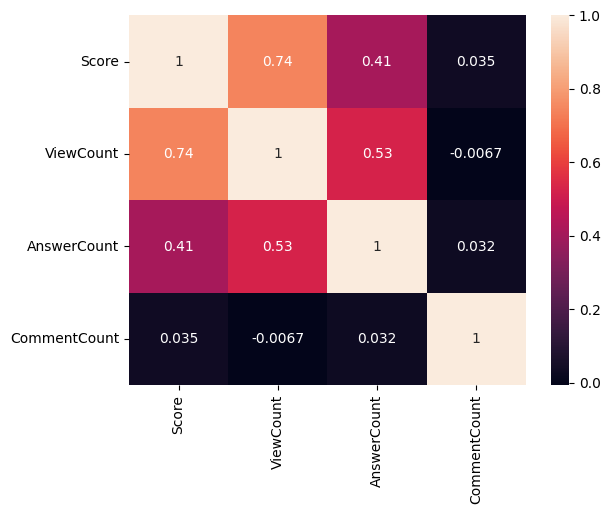

In [13]:
sns.heatmap(df[scores].corr(), annot=True)
plt.show()

The correlation is very low between the commentCount and the other scores. What is interesting is that there is a high correlation between the viewCount and the score, meaning that the more a post is seen, the higher score it get. 

# Tags preprocessing and selection  

Now we want to explore the tag by post, first we need to extract them trough a regex : 

In [14]:
def processTags(tags):
    # use regex to extract tags to list
    regex = "<([^>]+)>"
    tagslist = re.split(regex, tags)
    # filter None values
    tagslist_clean = filter(None, tagslist)
    # all tags to lower case
    return [str(x).lower() for x in tagslist_clean]

In [15]:
df["tag_list"] = df["Tags"].apply(processTags)

In [16]:

tag_count = df["tag_list"].explode().value_counts()

In [17]:
print(f"Number of unique tag : {len(tag_count)}") # number of unique tags 

Number of unique tag : 17160


There are 17148 different tags in the datasets, this is a lot for tag suggestion. So we will only keep a restricted number. Let's view the number of occurrence of each tag : 

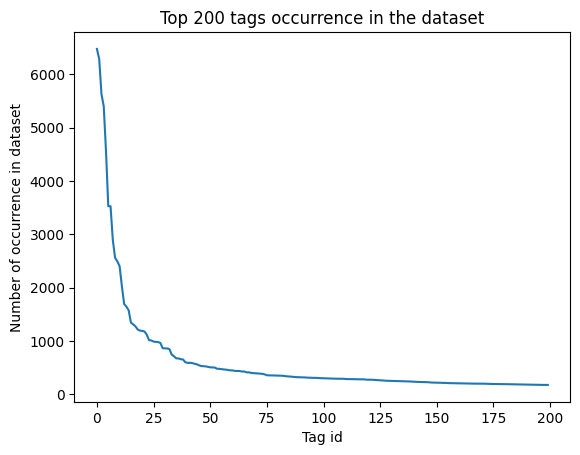

In [18]:
tags_series = pd.Series(df["tag_list"].explode())
plt.plot(tags_series.value_counts().head(200).values)
plt.xlabel("Tag id")
plt.ylabel("Number of occurrence in dataset")
plt.title("Top 200 tags occurrence in the dataset")
plt.show()

In [19]:
tag_cumsum = pd.DataFrame(index=tag_count.index)
tag_cumsum["occurrence"] = tag_count.values
tag_cumsum["cum_sum"] = tag_count.cumsum()
tag_cumsum["cum_sum_percentage"] = tag_count.cumsum() / tag_cumsum["occurrence"].sum() *100
tag_cumsum.head(30)

,occurrence,cum_sum,cum_sum_percentage
tag_list,,,
c#,6477,6477,2.590779
java,6287,12764,5.105559
c++,5629,18393,7.357141
javascript,5402,23795,9.517924
python,4552,28347,11.338709
ios,3528,31875,12.749898
android,3528,35403,14.161087
.net,2896,38299,15.319477
c,2560,40859,16.343469


Thanks to the graph and the cumulative table, I choose to select post that are tagged with top 30 tags and correspond to around 30% of the dataset

In [20]:
tag_list_to_keep = tag_cumsum.head(30).index
per = round(tag_cumsum['occurrence'].head(30).sum() / tag_cumsum['occurrence'].sum() * 100 ,3)

print(f"Tag list :\n {tag_list_to_keep}")
print(f"Pourcentage of tags within the list :  {per} % ")

Tag list :
 Index(['c#', 'java', 'c++', 'javascript', 'python', 'ios', 'android', '.net',
       'c', 'html', 'php', 'jquery', 'css', 'performance', 'objective-c',
       'linux', 'c++11', 'sql', 'iphone', 'node.js', 'algorithm', 'asp.net',
       'swift', 'arrays', 'spring', 'mysql', 'multithreading', 'windows',
       'xcode', 'json'],
      dtype='object', name='tag_list')
Pourcentage of tags within the list :  27.728 % 


In [21]:
def keep_most_used_tags(tag_list): 
    tag_list = [ str(tag)  for tag in tag_list   if tag in tag_list_to_keep]
    if not tag_list : # void
        tag_list = np.NaN
    return tag_list

In [22]:
df["tag_list_clean"] = df["tag_list"].apply(keep_most_used_tags)

In [23]:
df[["tag_list","tag_list_clean"]].head()

,tag_list,tag_list_clean
0,"[python, algorithm, nltk, wordnet, gensim]","[python, algorithm]"
1,"[web-services, json, cross-domain, jsonp, xss]",[json]
2,"[ruby-on-rails, ruby, testing, factory-bot, ma...",NaN
3,"[ruby-on-rails, ruby, memory, memory-leaks, ru...",NaN
4,"[c, arrays, pointers, dereference, operator-pr...","[c, arrays]"


# Posts selection 
### Select posts with minimum one tag within the selected list : 

In [24]:
df.dropna(subset="tag_list_clean",axis=0, inplace=True)

In [25]:

print(f" Percentage of posts remaining : {df.shape[0] / nb_posts * 100 } % with {df.shape[0]} posts ")

 Percentage of posts remaining : 85.922 % with 42961 posts 


Here is a subset example, nswindowcontrol was not kept. 

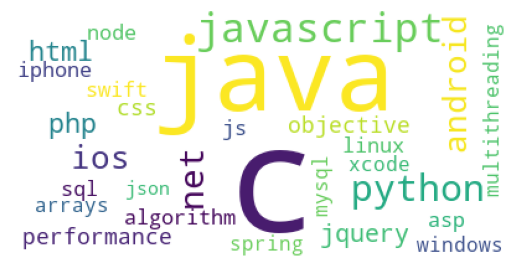

In [26]:
text = ' '.join(tuple(df["tag_list_clean"].explode()))

#create the wordcloud object
wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      max_words=50).generate(text)
                    #   font_path=r"C:\Users\Clara\Documents\dev\machine_learning\cours\NLP\GothamMedium.ttf"
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Post  length: 
remove interquartile outliers 

This post is very short, for better lets analyse the length of posts : 

In [27]:
def returnRawTextTromHTML(htmltext): 
    soup = BeautifulSoup(htmltext, 'html.parser')
    return soup.get_text()

def lengthOfDoc(doc) : 
    return len(doc.split())


In [28]:
df["Title_str"] = df["Title"].apply(returnRawTextTromHTML)

C:\Users\clara\AppData\Local\Temp\ipykernel_36376\1963510268.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(htmltext, 'html.parser')


In [29]:
df["Body_str"] = df["Body"].apply(returnRawTextTromHTML)

In [30]:
df["posts_length"] = df["Body_str"].apply(lengthOfDoc)

In [31]:
df["posts_length"].describe()

count    42961.000000
mean       215.937315
std        219.491461
min          6.000000
25%         93.000000
50%        155.000000
75%        262.000000
max      10725.000000
Name: posts_length, dtype: float64

Only keep post of more than 100 words : 

In [32]:
mask = df["posts_length"] < 100 
df.drop(df.loc[mask].index, inplace=True)

In [33]:
print(f" Percentage of posts remaining : {df.shape[0] / nb_posts * 100 } % with {df.shape[0]} posts ")

 Percentage of posts remaining : 61.824 % with 30912 posts 


# View first post : 

In [34]:

title = df.iloc[0][["Title"]][0]
bodyPost = df.iloc[0][["Body"]][0]
tags = df.iloc[0][["Tags"]][0]


tag_of_post = processTags(tags)


print("Title : ")
display(HTML(title))
print("Posts : ")
display(HTML(bodyPost))
print("Tags : ",' '.join(tag_of_post))


Title : 


Posts : 


Tags :  python algorithm nltk wordnet gensim


# From posts to data
## Handling HTML 

In [35]:
body_str = returnRawTextTromHTML(bodyPost)

## example of the first post 

In [36]:
print(df[["Body_str"]].iloc[0].values[0])

Big picture goal: I am making an LDA model of product reviews in Python using NLTK and Gensim. I want to run this on varying n-grams. 
Problem: Everything is great with unigrams, but when I run with bigrams, I start to get topics with repeated information. For example, Topic 1 might contain: ['good product', 'good value'], and Topic 4 might contain: ['great product', 'great value']. To a human these are obviously conveying the same information, but obviously 'good product' and 'great product' are distinct bigrams. How do I algorithmically determine that 'good product' and 'great product' are similar enough, so I can translate all occurrences of one of them to the other (maybe the one that appears more often in the corpus)?
What I've tried: I played around with WordNet's Synset tree, with little luck. It turns out that good is an 'adjective', but great is an 'adjective satellite', and therefore return None for path similarity. My thought process was to do the following:

Part of speech 

## Create dictionnary of the corpus 

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
englishstopwords = stopwords.words('english')

def tokenize(input_string) : 
    return  nltk.word_tokenize(input_string)

def lemmatize(word) : 
    return  WordNetLemmatizer().lemmatize(word)

def tokenize_stopwords_and_short_words_handling( body) : 
    tokens = []
    for token in tokenize(body) : 
        if token not in englishstopwords and len(token) > 3 : 
            word = lemmatize(token)
            tokens.append(word)
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
dic = ' '.join(df["Body_str"])

In [22]:
print("Example : ")
sentence = "Let's tokenize this sentence !! This will make a great example"
print(sentence)
tokenize_stopwords_and_short_words_handling( sentence)

Example : 
Let's tokenize this sentence !! This will make a great example


['tokenize', 'sentence', 'This', 'make', 'great', 'example']

In [39]:

for body in df["Body_str"] : 
    tokens = tokenize_stopwords_and_short_words_handling( body)


In [40]:
len(tokens)

4788033

In [41]:
token_series = pd.Series(tokens)
token_series = token_series[token_series.duplicated(keep=False)]
most_used_words_100 = token_series.value_counts().head(100).index

In [42]:
most_used_words_100

Index(['public', 'using', 'return', 'code', 'class', 'file', 'like',
       'function', 'error', 'work', 'would', 'data', 'android', 'void', 'http',
       'value', 'This', 'problem', 'import', 'time', 'string', 'want',
       'method', 'type', 'need', 'object', 'String', 'user', 'true',
       'following', 'line', 'result', 'name', 'private', 'tried',
       'application', 'test', 'question', 'know', 'version', 'also', 'example',
       'make', 'call', 'null', 'could', 'case', 'static', 'trying', 'project',
       'const', 'image', 'server', 'array', 'something', 'found', 'solution',
       'false', 'Here', 'class=', 'What', 'else', 'request', 'used', 'issue',
       'find', 'first', 'name=', 'page', 'main', 'text', 'change', 'working',
       'seems', 'thread', 'different', 'list', 'message', 'include', 'number',
       'still', 'help', 'view', 'input', 'When', 'look', 'table', 'However',
       'property', 'create', 'without', 'even', 'second', 'output', 'library',
       'point', '

In [17]:
most_used_words_100 = ['public', 'using', 'return', 'code', 'class', 'file', 'like',
       'function', 'error', 'work', 'would', 'data', 'android', 'void', 'http',
       'value', 'This', 'problem', 'import', 'time', 'string', 'want',
       'method', 'type', 'need', 'object', 'String', 'user', 'true',
       'following', 'line', 'result', 'name', 'private', 'tried',
       'application', 'test', 'question', 'know', 'version', 'also', 'example',
       'make', 'call', 'null', 'could', 'case', 'static', 'trying', 'project',
       'const', 'image', 'server', 'array', 'something', 'found', 'solution',
       'false', 'Here', 'class=', 'What', 'else', 'request', 'used', 'issue',
       'find', 'first', 'name=', 'page', 'main', 'text', 'change', 'working',
       'seems', 'thread', 'different', 'list', 'message', 'include', 'number',
       'still', 'help', 'view', 'input', 'When', 'look', 'table', 'However',
       'property', 'create', 'without', 'even', 'second', 'output', 'library',
       'point', 'item', 'memory', 'element', 'answer']

# remove most used words

In [43]:
token_list = token_series.values
token_series_clean = token_series[ ~token_series.isin(most_used_words_100) ]


## Word Cloud of corpus tokens 

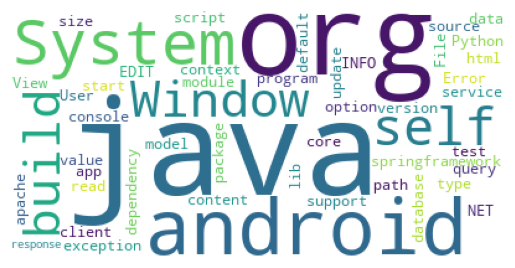

In [44]:
text = ' '.join(tuple(token_series_clean.values))

#create the wordcloud object
wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      max_words=50).generate(text)
                    #   font_path=r"C:\Users\Clara\Documents\dev\machine_learning\cours\NLP\GothamMedium.ttf"
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Title and posts body to bag-of-words Pipeline: 

In [18]:


def tokenize_stopwords_and_short_words_most_used_handling(input_string,  list_non_selected_tokens, pattern1 , pattern2) : 
    tokens = []
    for token in tokenize(input_string) : 
        if  len(token) > 3 : 
            if token not in list_non_selected_tokens : 
                if not pattern1.match(token) and not pattern2.match(token): 
                    word = lemmatize(token)
                    tokens.append(word)
    return tokens

In [19]:
def mysem(input_string) :
    regex1 = "^.*\/[^\/]+" 
    pattern1 = re.compile(regex1)
    regex2 = "([^-]*-+[^-]+)+"
    pattern2 = re.compile(regex2)
    urls = ['http', 'https']
    englishstopwords = stopwords.words('english')
    list_non_selected_words = np.concatenate((englishstopwords , most_used_words_100, urls))

    return tokenize_stopwords_and_short_words_most_used_handling(input_string, list_non_selected_words, pattern1, pattern2)

In [23]:
mysem( sentence)

['tokenize', 'sentence', 'great']

In [47]:

print(df[["Title_str"]].iloc[0].values[0])
print(mysem(df[["Title_str"]].iloc[0].values[0]))

NLTK - Automatically translating similar words
['NLTK', 'Automatically', 'translating', 'similar', 'word']


In [48]:
print(df[["Body_str"]].iloc[0].values[0])
print(mysem(df[["Body_str"]].iloc[0].values[0]))

Big picture goal: I am making an LDA model of product reviews in Python using NLTK and Gensim. I want to run this on varying n-grams. 
Problem: Everything is great with unigrams, but when I run with bigrams, I start to get topics with repeated information. For example, Topic 1 might contain: ['good product', 'good value'], and Topic 4 might contain: ['great product', 'great value']. To a human these are obviously conveying the same information, but obviously 'good product' and 'great product' are distinct bigrams. How do I algorithmically determine that 'good product' and 'great product' are similar enough, so I can translate all occurrences of one of them to the other (maybe the one that appears more often in the corpus)?
What I've tried: I played around with WordNet's Synset tree, with little luck. It turns out that good is an 'adjective', but great is an 'adjective satellite', and therefore return None for path similarity. My thought process was to do the following:

Part of speech 

In [49]:
bag_of_words_body = [] 
bag_of_words_titles = []
tags = []
corpus = []
pbar = tqdm.tqdm(total=df.shape[0])
for index, row in df.iterrows():
    body = row["Body_str"]
    title = row["Title_str"]
    tokens_body = mysem(body)
    tokens_title = mysem(title)
    
    corpus.append(f"{title}{body}")
    bag_of_words_body.append(tokens_body)
    bag_of_words_titles.append(tokens_title)
    tags.append(row["tag_list_clean"])
    
    pbar.update(1)
    
pbar.close()


100%|██████████| 30912/30912 [02:25<00:00, 212.09it/s]


# Analyze bag-of-words for  within body and title

In [50]:
def get_percentage_of_title_word_in_body(bag_of_words_body, bag_of_words_titles):
    sum_present = 0 
    sum_total = 0
    for doc_idx in range(len(bag_of_words_body)): 
        body_words = bag_of_words_body[doc_idx]
        body_title = bag_of_words_titles[doc_idx]
        number_of_title_word_present_in_body =  sum( 1 for word in body_title if word in body_words ) 
        
        sum_present = sum_present + number_of_title_word_present_in_body
        sum_total = sum_total + len(body_title)
    return (sum_present/sum_total) *100

In [51]:
per =  get_percentage_of_title_word_in_body(bag_of_words_body, bag_of_words_titles)
print(f"Percentage of words in title present in body : {per} % ")

Percentage of words in title present in body : 63.56289129197496 % 


There is an interest to keep both body and title tokens. Indeed, half of title tokens are not appearing in the body part. 

## Save tokenization and corpus for learning  

In [52]:
# Save words dictionary of the entire corpus : 
np.save(f"{output_dir}token_series_clean.npy", token_series_clean.values, allow_pickle=True,)
np.save(f"{output_dir}corpus.npy", corpus, allow_pickle=True)
np.save(f"{output_dir}corpus_tags.npy", tags, allow_pickle=True)
np.save(f"{output_dir}bag_of_words_body.npy", bag_of_words_body, allow_pickle=True)
np.save(f"{output_dir}bag_of_words_titles.npy", bag_of_words_titles, allow_pickle=True)

c:\dev\topic_modelling\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Number of tokens per document 

In [8]:
NB_DOCS = bag_of_words_body.shape[0]
print(f"Number of posts remaining : {NB_DOCS}")
nb_tokens = np.array([])
for i in range (NB_DOCS) : 
    nb_token = len(bag_of_words_titles[i]) + len(bag_of_words_body[i])
    nb_tokens = np.append(nb_tokens, nb_token)
    

Number of posts remaining : 30912


In [10]:
pd.Series(nb_tokens).describe()

count    30912.000000
mean       122.673395
std        117.266411
min         15.000000
25%         59.000000
50%         87.000000
75%        141.000000
max       2368.000000
dtype: float64

Remaining articles are represented from 15 to more 2000 tokens with a median around 100 tokens. 